# Model Training for Elongation Prediction

This notebook trains multiple regression models on PCA-transformed data and compares their performance using GridSearchCV with 5-fold cross-validation.

**Elongation (%)** measures ductility - the capacity of welded material to undergo plastic deformation before fracture. It's critical for structural applications where the material must absorb energy during loading.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib
import os

In [2]:
os.makedirs('trained_models', exist_ok=True)

In [ ]:
df = pd.read_csv('data/welddb_pca_elongation.csv')
print(f"Dataset shape: {df.shape}")

Dataset shape: (700, 18)


In [4]:
X = df.drop('Elongation_%', axis=1)
y = df['Elongation_%']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 560
Testing samples: 140


## Model Definitions

In [5]:
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0),
    'LightGBM': LGBMRegressor(random_state=42, verbosity=-1),
    'SVR': SVR()
}

In [6]:
param_grids = {
    'Ridge': {'alpha': [0.1, 1, 10, 100]},
    'Lasso': {'alpha': [0.01, 0.1, 1, 10]},
    'ElasticNet': {'alpha': [0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]},
    'DecisionTree': {
        'max_depth': [10, 15, 20],
        'min_samples_split': [5, 10, 20],
        'min_samples_leaf': [4, 8, 12]
    },
    'RandomForest': {
        'n_estimators': [200, 300],
        'max_depth': [15, 20, 25],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [2, 4],
        'max_features': ['sqrt']
    },
    'GradientBoosting': {
        'n_estimators': [200, 300, 400],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [4, 5, 6],
        'subsample': [0.8, 0.9],
        'min_samples_split': [5, 10]
    },
    'XGBoost': {
        'n_estimators': [200, 300, 400],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [4, 5, 6, 7],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9],
        'min_child_weight': [1, 3]
    },
    'LightGBM': {
        'n_estimators': [200, 300, 400],
        'learning_rate': [0.05, 0.1, 0.15],
        'max_depth': [5, 7, 9],
        'num_leaves': [50, 70],
        'subsample': [0.8, 0.9],
        'min_child_samples': [20, 30]
    },
    'SVR': {
        'C': [1, 10, 50],
        'kernel': ['rbf'],
        'gamma': ['scale', 0.01, 0.1],
        'epsilon': [0.1, 0.2]
    }
}

## Training with GridSearchCV

In [7]:
results = []

for name, model in models.items():
    print(f"Training {name}...")
    
    grid = GridSearchCV(
        model, param_grids[name],
        cv=5, scoring='r2',
        n_jobs=-1, verbose=0
    )
    
    grid.fit(X_train, y_train)
    
    y_train_pred = grid.predict(X_train)
    y_test_pred = grid.predict(X_test)
    
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    
    results.append({
        'Model': name,
        'Best_Params': str(grid.best_params_),
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Test_MAE': test_mae,
        'Test_RMSE': test_rmse
    })
    
    joblib.dump(grid.best_estimator_, f'trained_models/{name}_model.pkl')
    print(f"  Best params: {grid.best_params_}")
    print(f"  Train R2: {train_r2:.4f} | Test R2: {test_r2:.4f}")
    print()

Training Ridge...
  Best params: {'alpha': 100}
  Train R2: 0.3719 | Test R2: 0.3658

Training Lasso...
  Best params: {'alpha': 0.1}
  Train R2: 0.2824 | Test R2: 0.2765

Training ElasticNet...
  Best params: {'alpha': 100}
  Train R2: 0.3719 | Test R2: 0.3658

Training Lasso...
  Best params: {'alpha': 0.1}
  Train R2: 0.2824 | Test R2: 0.2765

Training ElasticNet...
  Best params: {'alpha': 0.1, 'l1_ratio': 0.2}
  Train R2: 0.3668 | Test R2: 0.3587

Training DecisionTree...
  Best params: {'alpha': 0.1, 'l1_ratio': 0.2}
  Train R2: 0.3668 | Test R2: 0.3587

Training DecisionTree...
  Best params: {'max_depth': 10, 'min_samples_leaf': 12, 'min_samples_split': 5}
  Train R2: 0.6973 | Test R2: 0.4323

Training RandomForest...
  Best params: {'max_depth': 10, 'min_samples_leaf': 12, 'min_samples_split': 5}
  Train R2: 0.6973 | Test R2: 0.4323

Training RandomForest...
  Best params: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 

## Results Comparison

In [8]:
results_df = pd.DataFrame(results)

# Calculate overfitting metrics
results_df['Overfit_Gap'] = results_df['Train_R2'] - results_df['Test_R2']
results_df['Overfit_Percentage'] = (results_df['Overfit_Gap'] / results_df['Train_R2']) * 100

results_df = results_df.sort_values('Test_R2', ascending=False)
results_df.to_csv('trained_models/model_comparison.csv', index=False)

print("="*100)
print("MODEL PERFORMANCE COMPARISON")
print("="*100)
print(results_df[['Model', 'Train_R2', 'Test_R2', 'Overfit_Gap', 'Test_MAE', 'Test_RMSE']].to_string(index=False))
print("="*100)

MODEL PERFORMANCE COMPARISON
           Model  Train_R2  Test_R2  Overfit_Gap  Test_MAE  Test_RMSE
             SVR  0.878539 0.696243     0.182296  0.426156   0.565568
         XGBoost  0.975243 0.673830     0.301412  0.416980   0.586062
        LightGBM  0.957160 0.673620     0.283539  0.443191   0.586251
GradientBoosting  0.973784 0.670407     0.303377  0.424881   0.589130
    RandomForest  0.888175 0.646016     0.242159  0.465176   0.610540
    DecisionTree  0.697277 0.432342     0.264935  0.611659   0.773153
           Ridge  0.371944 0.365769     0.006174  0.640462   0.817233
      ElasticNet  0.366788 0.358737     0.008051  0.642589   0.821751
           Lasso  0.282422 0.276456     0.005966  0.686064   0.872880


### Overfitting Analysis

Analyze the gap between training and testing performance to identify overfitting.

In [9]:
# Overfitting classification
def classify_overfitting(gap):
    if gap < 0.05:
        return 'Excellent (No overfitting)'
    elif gap < 0.10:
        return 'Good (Slight overfitting)'
    elif gap < 0.15:
        return 'Moderate (Some overfitting)'
    else:
        return 'High (Severe overfitting)'

results_df['Overfit_Status'] = results_df['Overfit_Gap'].apply(classify_overfitting)

print("\nOVERFITTING ANALYSIS:")
print("-" * 80)
for _, row in results_df.iterrows():
    print(f"{row['Model']:20s} | Gap: {row['Overfit_Gap']:6.4f} | {row['Overfit_Status']}")
print("-" * 80)


OVERFITTING ANALYSIS:
--------------------------------------------------------------------------------
SVR                  | Gap: 0.1823 | High (Severe overfitting)
XGBoost              | Gap: 0.3014 | High (Severe overfitting)
LightGBM             | Gap: 0.2835 | High (Severe overfitting)
GradientBoosting     | Gap: 0.3034 | High (Severe overfitting)
RandomForest         | Gap: 0.2422 | High (Severe overfitting)
DecisionTree         | Gap: 0.2649 | High (Severe overfitting)
Ridge                | Gap: 0.0062 | Excellent (No overfitting)
ElasticNet           | Gap: 0.0081 | Excellent (No overfitting)
Lasso                | Gap: 0.0060 | Excellent (No overfitting)
--------------------------------------------------------------------------------


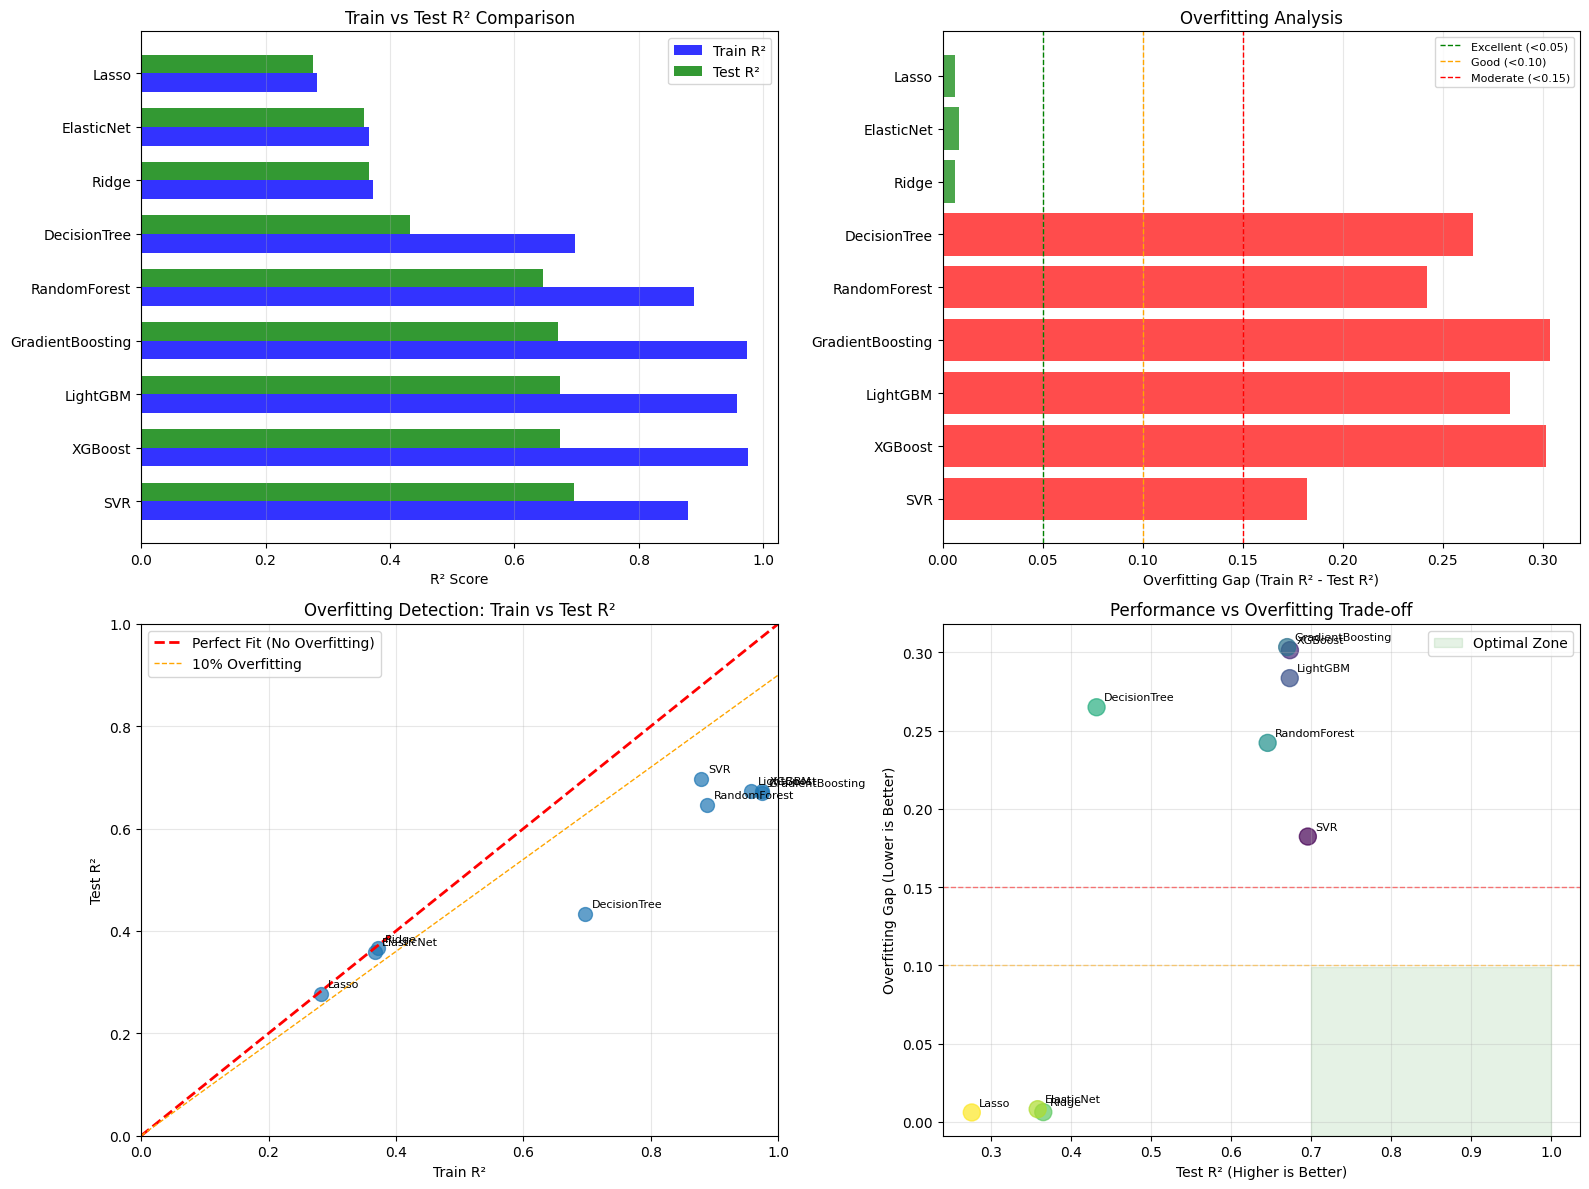


Visualization saved: trained_models/overfitting_analysis.png


In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Train vs Test R2 Comparison
ax1 = axes[0, 0]
x = np.arange(len(results_df))
width = 0.35
ax1.barh(x - width/2, results_df['Train_R2'], width, label='Train R²', alpha=0.8, color='blue')
ax1.barh(x + width/2, results_df['Test_R2'], width, label='Test R²', alpha=0.8, color='green')
ax1.set_yticks(x)
ax1.set_yticklabels(results_df['Model'])
ax1.set_xlabel('R² Score')
ax1.set_title('Train vs Test R² Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='x')

# 2. Overfitting Gap
ax2 = axes[0, 1]
colors = ['red' if gap > 0.15 else 'orange' if gap > 0.10 else 'yellow' if gap > 0.05 else 'green' 
          for gap in results_df['Overfit_Gap']]
ax2.barh(results_df['Model'], results_df['Overfit_Gap'], color=colors, alpha=0.7)
ax2.set_xlabel('Overfitting Gap (Train R² - Test R²)')
ax2.set_title('Overfitting Analysis')
ax2.axvline(x=0.05, color='green', linestyle='--', linewidth=1, label='Excellent (<0.05)')
ax2.axvline(x=0.10, color='orange', linestyle='--', linewidth=1, label='Good (<0.10)')
ax2.axvline(x=0.15, color='red', linestyle='--', linewidth=1, label='Moderate (<0.15)')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3, axis='x')

# 3. Train vs Test Scatter
ax3 = axes[1, 0]
ax3.scatter(results_df['Train_R2'], results_df['Test_R2'], s=100, alpha=0.7)
for i, model in enumerate(results_df['Model']):
    ax3.annotate(model, (results_df['Train_R2'].iloc[i], results_df['Test_R2'].iloc[i]), 
                 fontsize=8, xytext=(5, 5), textcoords='offset points')
ax3.plot([0, 1], [0, 1], 'r--', label='Perfect Fit (No Overfitting)', linewidth=2)
ax3.plot([0, 1], [0, 0.9], 'orange', linestyle='--', label='10% Overfitting', linewidth=1)
ax3.set_xlabel('Train R²')
ax3.set_ylabel('Test R²')
ax3.set_title('Overfitting Detection: Train vs Test R²')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])

# 4. Performance vs Overfitting Trade-off
ax4 = axes[1, 1]
scatter = ax4.scatter(results_df['Test_R2'], results_df['Overfit_Gap'], 
                      s=150, alpha=0.7, c=range(len(results_df)), cmap='viridis')
for i, model in enumerate(results_df['Model']):
    ax4.annotate(model, (results_df['Test_R2'].iloc[i], results_df['Overfit_Gap'].iloc[i]), 
                 fontsize=8, xytext=(5, 5), textcoords='offset points')
ax4.axhline(y=0.10, color='orange', linestyle='--', linewidth=1, alpha=0.5)
ax4.axhline(y=0.15, color='red', linestyle='--', linewidth=1, alpha=0.5)
ax4.set_xlabel('Test R² (Higher is Better)')
ax4.set_ylabel('Overfitting Gap (Lower is Better)')
ax4.set_title('Performance vs Overfitting Trade-off')
ax4.grid(True, alpha=0.3)

# Add optimal zone
ax4.axvspan(0.7, 1.0, ymin=0, ymax=0.33, alpha=0.1, color='green', label='Optimal Zone')
ax4.legend()

plt.tight_layout()
plt.savefig('trained_models/overfitting_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved: trained_models/overfitting_analysis.png")

### Best Model Selection (Balanced Performance)

In [11]:
# Calculate composite score: Test R2 - Overfitting Penalty
results_df['Composite_Score'] = results_df['Test_R2'] - (results_df['Overfit_Gap'] * 0.5)
results_df_balanced = results_df.sort_values('Composite_Score', ascending=False)

print("\n" + "="*100)
print("BEST MODEL RECOMMENDATIONS")
print("="*100)

print("\n1. BEST TEST PERFORMANCE (Highest Test R²):")
best_test = results_df.iloc[0]
print(f"   Model: {best_test['Model']}")
print(f"   Test R²: {best_test['Test_R2']:.4f}")
print(f"   Overfitting Gap: {best_test['Overfit_Gap']:.4f} ({best_test['Overfit_Status']})")

print("\n2. MOST BALANCED MODEL (Best Composite Score):")
best_balanced = results_df_balanced.iloc[0]
print(f"   Model: {best_balanced['Model']}")
print(f"   Test R²: {best_balanced['Test_R2']:.4f}")
print(f"   Overfitting Gap: {best_balanced['Overfit_Gap']:.4f} ({best_balanced['Overfit_Status']})")
print(f"   Composite Score: {best_balanced['Composite_Score']:.4f}")

print("\n3. LEAST OVERFITTING MODEL:")
best_no_overfit = results_df.sort_values('Overfit_Gap').iloc[0]
print(f"   Model: {best_no_overfit['Model']}")
print(f"   Test R²: {best_no_overfit['Test_R2']:.4f}")
print(f"   Overfitting Gap: {best_no_overfit['Overfit_Gap']:.4f} ({best_no_overfit['Overfit_Status']})")

print("\n" + "="*100)
print(f"RECOMMENDED MODEL: {best_balanced['Model']}")
print("="*100)


BEST MODEL RECOMMENDATIONS

1. BEST TEST PERFORMANCE (Highest Test R²):
   Model: SVR
   Test R²: 0.6962
   Overfitting Gap: 0.1823 (High (Severe overfitting))

2. MOST BALANCED MODEL (Best Composite Score):
   Model: SVR
   Test R²: 0.6962
   Overfitting Gap: 0.1823 (High (Severe overfitting))
   Composite Score: 0.6051

3. LEAST OVERFITTING MODEL:
   Model: Lasso
   Test R²: 0.2765
   Overfitting Gap: 0.0060 (Excellent (No overfitting))

RECOMMENDED MODEL: SVR


In [12]:
best_model_name = results_df.iloc[0]['Model']
best_test_r2 = results_df.iloc[0]['Test_R2']

print(f"\nBest Model: {best_model_name}")
print(f"Test R2: {best_test_r2:.4f}")


Best Model: SVR
Test R2: 0.6962


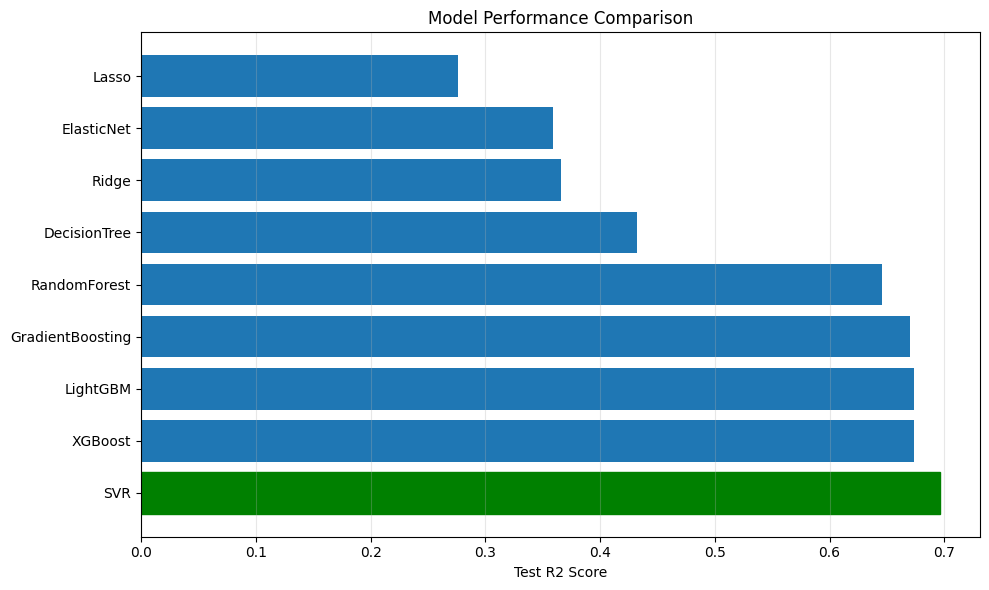

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

models_sorted = results_df['Model'].values
test_r2_sorted = results_df['Test_R2'].values

bars = ax.barh(models_sorted, test_r2_sorted)
bars[0].set_color('green')

ax.set_xlabel('Test R2 Score')
ax.set_title('Model Performance Comparison')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('trained_models/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Save Test Data

In [15]:
test_data = X_test.copy()
test_data['Elongation_%'] = y_test.values
test_data.to_csv('data/test_data.csv', index=False)

print(f"Shape: {test_data.shape}")

Shape: (140, 18)
